# Liver-Cirrhosis-Classification

# Imports

In [41]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

# Models 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier
from xgboost import XGBClassifier

# Data Processing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import make_scorer
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA


# Model Processing
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# K Best columns
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif


# Functions

In [42]:
def check_for_dupes_nans(df:pd.DataFrame):
    """
    Checks for dupes and nulls
    """
    amount_of_dupes = df.duplicated().sum()
    print(f"Null Count: {df.isna().sum()}")
    print(f"Dupe Count: {amount_of_dupes}")

def check_class_imbalance(df:pd.DataFrame, target:pd.Series, col:str):
  counter = Counter(target)
  for k,v in counter.items():
    per = v/len(target) * 100
    print("Class=%s, Count=%d, Percentage=%.3f%%" % (k,v, per))
  
  ax = df[col].value_counts().sort_index().plot(
  kind="bar", 
  title="Count of Reviews by Target", 
  figsize=(10,5)
  )
  ax.set_xlabel(col)
  plt.show()
  
def create_column_transformer( numeric_features, categorical_features):
  
  numeric_features_columns = numeric_features.columns
  numeric_transformer = Pipeline(
      steps=[("scaler", StandardScaler()), ("power_tranformer",PowerTransformer())]
  )

  categorical_features_columns = categorical_features.columns
  categorical_transformer = Pipeline(
      steps=[
          ("encoder", OneHotEncoder(handle_unknown="ignore")),
      ]
  )
  preprocessor = ColumnTransformer(
      transformers=[
          ("num", numeric_transformer, numeric_features_columns),
          ("cat", categorical_transformer, categorical_features_columns),
      ]
  )
  
  return preprocessor

def create_pipeline(preprocessor, model, metric_name=None, kbest=None):
    """
    - This function creates our pipeline.
    - Takes a preprocessor which transforms cat/numeric features
    - Can accept a metric
    - Model to test

    Returns:
        Pipeline
    """
    
    steps = [("preprocessor", preprocessor), ("model", model)]
    if kbest:
        steps.insert(1, ((metric_name,kbest)))
    return Pipeline(steps=steps) 

def evaluate_model(X:pd.Series, y:pd.Series, model):
    """
    This function takes in X, y values
    scores model performance based on
    subsets of data

    Returns:
        scores of models
    """
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
    
    metric = make_scorer(accuracy_score)
    scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
    return scores

def create_confusion_matrix(model_name:str, y_test:pd.Series, y_test_pred:pd.Series):
    """
    This function displays a classificaiton report
    & a Confusion Matrix

    Args:
        model_name (str): _description_
        y_test (pd.Series): _description_
        y_test_pred (pd.Series): _description_
    """
    
    cr = classification_report(y_test, y_test_pred)
    print(cr)
    conf_mat = confusion_matrix(y_test,y_test_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix {model_name}')
    plt.show()

def testing_selected_models(names:list, models:list, X:pd.DataFrame, y:pd.Series, 
                            preprocessor):
    """
    Runs multiple subsets on folds of data

    Args:
        names (list): _description_
        models (list): _description_
    """
    model_performance = []
    for i in range(len(models)):
        model = models[i]
        pipeline = create_pipeline(preprocessor, model)
        scores = evaluate_model(X, y, pipeline)
        model_performance.append({
            "Model": names[i],
            "Mean": np.mean(scores),
            "STD":np.std(scores)
        })
    performance_df = pd.DataFrame(model_performance)
    return performance_df.sort_values(by="Mean", ascending=False)
  
def get_selected_models(names):
  """
  Returns selected models for ML processing

  Args:
      names (_type_):List

  Returns:
      List of models
  """
  models = {
    "LDA": LinearDiscriminantAnalysis(),
    "GPC": GaussianProcessClassifier(),
    "GNB": GaussianNB(),
    "SVC": SVC(),
    "LR":LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "DTC": DecisionTreeClassifier(),
    "GBC":GradientBoostingClassifier(),
    "RFC":RandomForestClassifier(),
    "XGB": XGBClassifier(),
    "MN": MultinomialNB()
  }
  
  return [models[model] for model in names]

def val_grid_search_selected_models(names:list, models:list, X:pd.DataFrame, 
    y:pd.Series, metric, preprocessor, param_grid=None, kbest=None, kbest_name=None):
    """
    Runs multiple models on subsets of data
    using grid search
    - Grabs best Validation score
    - Grabs best accuracy score
    - Grabs best model Params
    """
    
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    model_performance = []

    for i in range(len(models)):
        model, name = models[i], names[i]
        pipeline = create_pipeline(preprocessor, model, kbest_name, kbest) if kbest_name else create_pipeline(preprocessor, model)
        if param_grid:
            grid_search = GridSearchCV(pipeline, param_grid[name], cv=5, scoring=metric, n_jobs=-1)
            grid_search.fit(X_train, y_train)
            best_model = grid_search.best_estimator_
            
            print(f'Best score for {name}: {grid_search.best_score_:.3f}')
            print("Best parameters:", grid_search.best_params_)
        
        else:
            best_model = pipeline
            best_model.fit(X_train, y_train)
        
        y_pred = best_model.predict(X_val)
        y_test_pred = best_model.predict(X_test)
            
        val_accuracy = accuracy_score(y_val, y_pred)
        test_accuracy = accuracy_score(y_test, y_test_pred)
        
        print(f'Validation Test accuracy for {name}: {val_accuracy:.3f}')
        print(f'Test accuracy for {name}: {test_accuracy:.3f}')
        print("---------------------------------------------------------------")
        create_confusion_matrix(name, y_test, y_test_pred)
            
        model_performance.append({
                "Model": name,
                "Validation Accuracy": val_accuracy,
                "Test Accuracy": test_accuracy,
        })
    return pd.DataFrame(model_performance).sort_values(by="Test Accuracy", ascending=False)

def pca_analysis(X, preprocessor):
  
    features = X.shape[1]
    results = []
    for n_components in range(1, features + 1):
        pca = PCA(n_components=n_components)
        pipeline = create_pipeline(preprocessor, pca)
        pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("pca", pca)])
        X_pca = pipeline.fit_transform(X)
        
        explained_variance = np.sum(pca.explained_variance_ratio_)
        
        results.append({
            'Number of Components': n_components,
            'Cumulative Explained Variance': explained_variance
        })
    results_df = pd.DataFrame(results)
    return results_df

def test_k_best_columns(names, models, X, y, metric, metric_name, variance_window, preprocessor):
    model_performance = []
    total_score, runs = 0, 0
    for k in variance_window:
        fs = SelectKBest(score_func=metric, k=k)
        for i in range(len(models)):
            model = models[i]
            pipeline = create_pipeline(preprocessor, model, metric_name, fs)
            scores = evaluate_model(X, y, pipeline)
            mean_score = np.mean(scores)
            total_score += mean_score
            runs+=1
            model_performance.append({
                "Model": names[i],
                "Col #": k,
                "Metric": metric_name,
                "Mean": mean_score,
                "STD":np.std(scores)
            })
    performance_df = pd.DataFrame(model_performance)
    print(f"Average total Score: {total_score/runs}")
    return performance_df.sort_values(by="Mean", ascending=False)


# EDA Analysis

In [43]:
df = pd.read_csv("/Users/maukanmir/Downloads/liver_cirrhosis.csv")
df

,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,2221,C,Placebo,18499,F,N,Y,N,N,0.5,149.000000,4.04,227.0,598.0,52.70,57.000000,256.0,9.9,1
1,1230,C,Placebo,19724,M,Y,N,Y,N,0.5,219.000000,3.93,22.0,663.0,45.00,75.000000,220.0,10.8,2
2,4184,C,Placebo,11839,F,N,N,N,N,0.5,320.000000,3.54,51.0,1243.0,122.45,80.000000,225.0,10.0,2
3,2090,D,Placebo,16467,F,N,N,N,N,0.7,255.000000,3.74,23.0,1024.0,77.50,58.000000,151.0,10.2,2
4,2105,D,Placebo,21699,F,N,Y,N,N,1.9,486.000000,3.54,74.0,1052.0,108.50,109.000000,151.0,11.5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,3584,D,D-penicillamine,23612,F,N,N,N,N,0.8,231.000000,3.87,173.0,9009.8,127.71,96.000000,295.0,11.0,2
24996,3584,D,D-penicillamine,23612,F,N,N,N,N,0.8,231.000000,3.87,173.0,9009.8,127.71,96.000000,295.0,11.0,2
24997,971,D,D-penicillamine,16736,F,N,Y,Y,Y,5.1,369.510563,3.23,18.0,790.0,179.80,124.702128,104.0,13.0,3
24998,3707,C,D-penicillamine,16990,F,N,Y,N,N,0.8,315.000000,4.24,13.0,1637.0,170.50,70.000000,426.0,10.9,2


# Check For Nulls and Dupes

In [44]:
check_for_dupes_nans(df)

Null Count: N_Days           0
Status           0
Drug             0
Age              0
Sex              0
Ascites          0
Hepatomegaly     0
Spiders          0
Edema            0
Bilirubin        0
Cholesterol      0
Albumin          0
Copper           0
Alk_Phos         0
SGOT             0
Tryglicerides    0
Platelets        0
Prothrombin      0
Stage            0
dtype: int64
Dupe Count: 15361


# Dupe Count is over 15K

In [45]:
print(f"Non Duplicated values is: {len(df) - df.duplicated().sum()}")

Non Duplicated values is: 9639


In [46]:
df.drop_duplicates(inplace=True)

# Check For Class Imbalance

Class=1, Count=3025, Percentage=31.383%
Class=2, Count=3308, Percentage=34.319%
Class=3, Count=3306, Percentage=34.298%


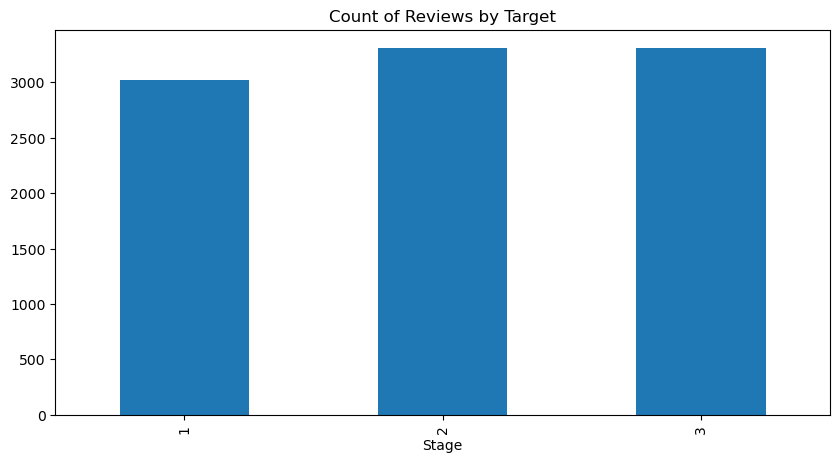

In [47]:
check_class_imbalance(df,df['Stage'], 'Stage')

# Balanced Dataset

In [48]:
df.dtypes

N_Days             int64
Status            object
Drug              object
Age                int64
Sex               object
Ascites           object
Hepatomegaly      object
Spiders           object
Edema             object
Bilirubin        float64
Cholesterol      float64
Albumin          float64
Copper           float64
Alk_Phos         float64
SGOT             float64
Tryglicerides    float64
Platelets        float64
Prothrombin      float64
Stage              int64
dtype: object

In [49]:
df.describe()

,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
count,9639.000000,9639.000000,9639.000000,9639.000000,9639.000000,9639.000000,9639.000000,9639.000000,9639.000000,9639.000000,9639.000000,9639.000000
mean,1910.982571,18429.717606,3.228571,371.706706,3.496118,97.027569,1973.572709,122.317487,123.587337,253.787605,10.713328,2.029152
std,1093.620373,3693.953156,4.512278,197.824339,0.382319,73.108854,1827.063380,47.653515,55.206301,95.740700,0.922026,0.809956
min,41.000000,9598.000000,0.300000,120.000000,1.960000,4.000000,289.000000,26.350000,33.000000,62.000000,9.000000,1.000000
25%,1103.000000,15628.000000,0.800000,271.000000,3.290000,51.000000,1031.000000,89.900000,93.000000,188.000000,10.000000,1.000000
50%,1690.000000,18628.000000,1.300000,369.510563,3.520000,97.648387,1713.000000,122.556346,124.702128,249.000000,10.600000,2.000000
75%,2598.000000,20819.000000,3.300000,369.510563,3.760000,102.000000,1982.655769,134.850000,125.000000,307.000000,11.100000,3.000000
max,4795.000000,28650.000000,28.000000,1775.000000,4.640000,588.000000,13862.400000,457.250000,598.000000,721.000000,18.000000,3.000000


In [50]:
categorical_features, numeric_features = df.select_dtypes(include="object"), df.select_dtypes(include=["int64", "float64"]).drop("Stage", axis=1)

In [51]:
for col in categorical_features.columns:
  print(f"Unqiue column values for col: {col} = {categorical_features[col].unique()}")

Unqiue column values for col: Status = ['C' 'D' 'CL']
Unqiue column values for col: Drug = ['Placebo' 'D-penicillamine']
Unqiue column values for col: Sex = ['F' 'M']
Unqiue column values for col: Ascites = ['N' 'Y']
Unqiue column values for col: Hepatomegaly = ['Y' 'N']
Unqiue column values for col: Spiders = ['N' 'Y']
Unqiue column values for col: Edema = ['N' 'Y' 'S']


# Visuals

<AxesSubplot:>

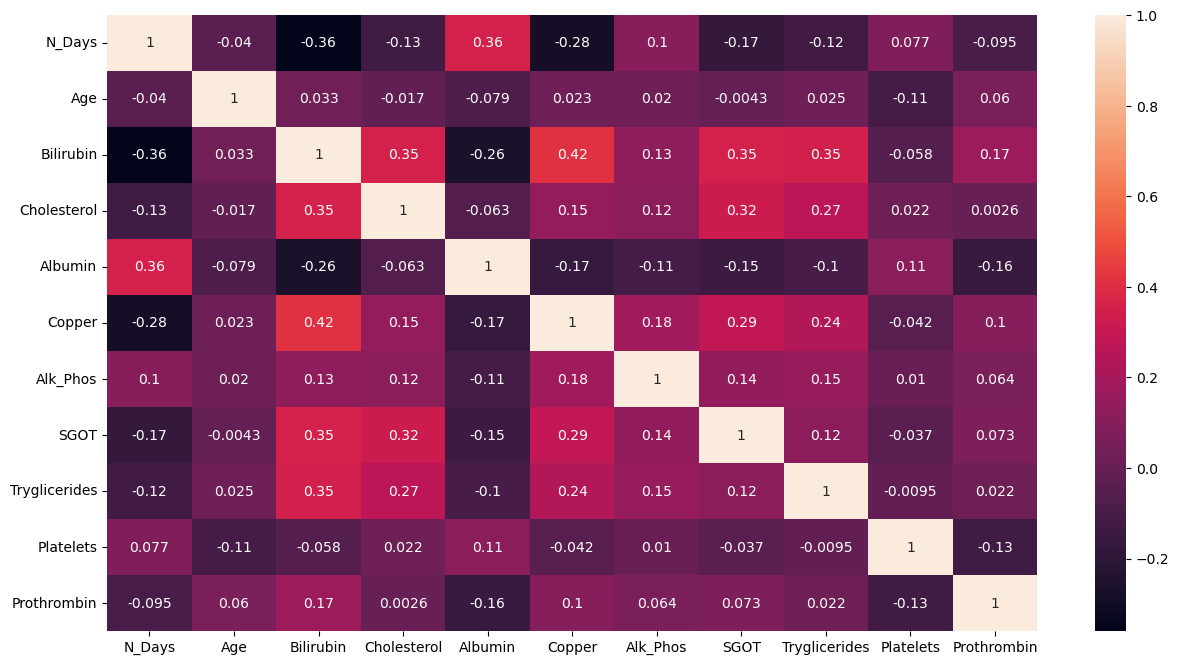

In [52]:
plt.figure(figsize=(15,8))
sns.heatmap(data=numeric_features.corr(), annot=True)

# Some features seem to be correlated together, this could potentially interfere in the modeling process. This could also be stasitical noise due to number of feartures. We will have to explore.

# Separate and Scale feature variables

In [53]:
X,y = df.drop("Stage", axis=1), df['Stage']

# Preprocessor Pipeline

In [54]:
preprocessor = create_column_transformer(numeric_features, categorical_features)

# Baseline Model

In [55]:
model = DummyClassifier(strategy="uniform")
pipeline = create_pipeline(preprocessor, model)
scores = evaluate_model(X, y, pipeline)
print(f"Mean: {round(np.mean(scores),3)}, STD: {round(np.std(scores),3)}")

Mean: 0.335, STD: 0.014


# Advanced Metrics

In [56]:
names = ['LR', 'SVC']
models = get_selected_models(names)
testing_selected_models(names, models, X, y, preprocessor)

,Model,Mean,STD
1,SVC,0.702770,0.009342
0,LR,0.562127,0.007336


In [57]:
names = ["RFC", "DTC"]
models = get_selected_models(names)
testing_selected_models(names, models, X, y, preprocessor)

In [ ]:
names = ["GBC"]
models = get_selected_models(names)
testing_selected_models(names, models, X, y, preprocessor)

,Model,Mean,STD
0,GBC,0.776948,0.009898


# Let's try some hyper parameter tuning

Best score for LR: 0.552
Best parameters: {'model__C': 0.1, 'model__solver': 'newton-cg'}
Validation Test accuracy for LR: 0.585
Test accuracy for LR: 0.584
---------------------------------------------------------------
              precision    recall  f1-score   support

           1       0.57      0.55      0.56       484
           2       0.45      0.43      0.44       449
           3       0.69      0.75      0.72       513

    accuracy                           0.58      1446
   macro avg       0.57      0.58      0.57      1446
weighted avg       0.58      0.58      0.58      1446



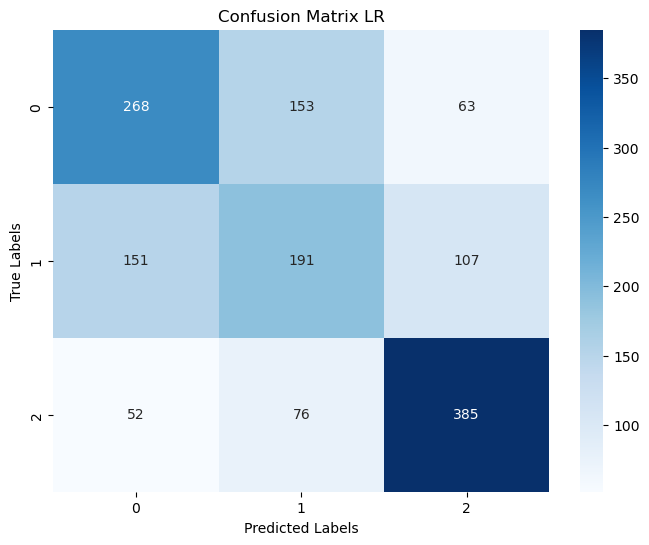

Best score for SVC: 0.693
Best parameters: {'model__C': 1, 'model__kernel': 'poly'}
Validation Test accuracy for SVC: 0.719
Test accuracy for SVC: 0.708
---------------------------------------------------------------
              precision    recall  f1-score   support

           1       0.74      0.62      0.68       484
           2       0.59      0.71      0.65       449
           3       0.81      0.79      0.80       513

    accuracy                           0.71      1446
   macro avg       0.71      0.71      0.71      1446
weighted avg       0.72      0.71      0.71      1446



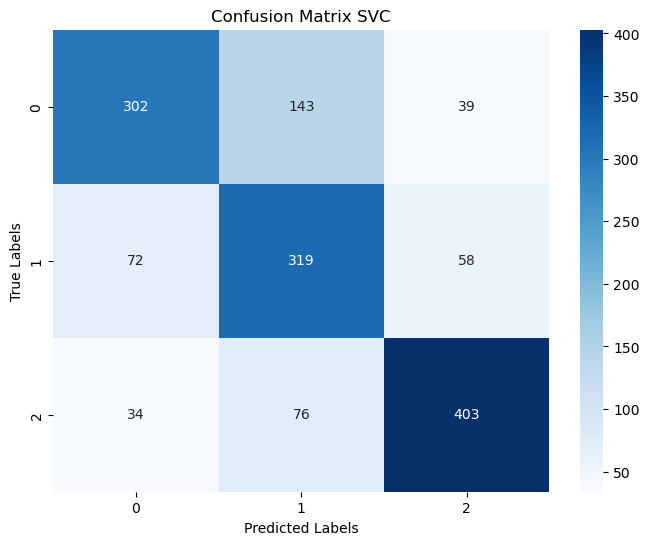

,Model,Validation Accuracy,Test Accuracy
1,SVC,0.718534,0.708160
0,LR,0.585062,0.583679


In [ ]:
param_grid = {
  "LR":{
        'model__solver': ['newton-cg', 'sag', 'saga', 'lbfgs'],
        'model__C': [0.1, 0.2, 0.4, 0.5, 1, 2, 4, 5, 10, 20, 50, 100, 400]
  },
  "SVC": {
        'model__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'model__C': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
  }
    }

names = ["LR", "SVC"]
models = get_selected_models(names)
metric = make_scorer(accuracy_score)
val_grid_search_selected_models(names, models, X, y, metric, preprocessor, param_grid)

Best score for RFC: 0.860
Best parameters: {'model__max_depth': 30, 'model__min_samples_leaf': 1, 'model__min_samples_split': 5, 'model__n_estimators': 300}
Validation Test accuracy for RFC: 0.871
Test accuracy for RFC: 0.873
---------------------------------------------------------------
              precision    recall  f1-score   support

           1       0.89      0.85      0.87       484
           2       0.82      0.84      0.83       449
           3       0.90      0.92      0.91       513

    accuracy                           0.87      1446
   macro avg       0.87      0.87      0.87      1446
weighted avg       0.87      0.87      0.87      1446



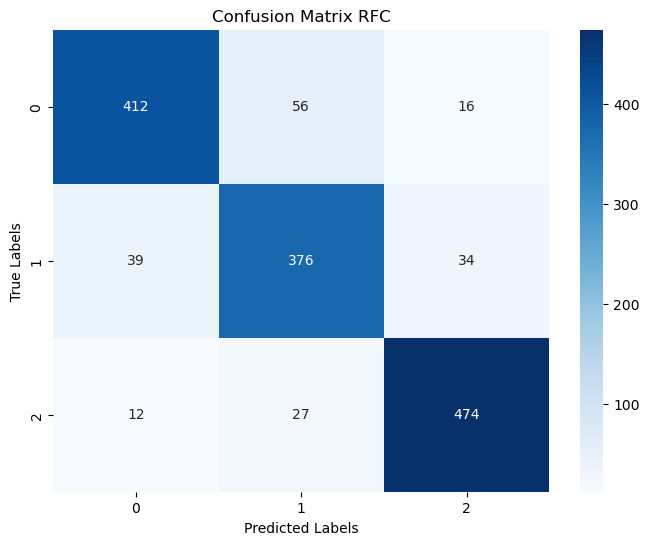

Best score for GBC: 0.898
Best parameters: {'model__learning_rate': 0.1, 'model__max_depth': 7, 'model__n_estimators': 300}
Validation Test accuracy for GBC: 0.906
Test accuracy for GBC: 0.911
---------------------------------------------------------------
              precision    recall  f1-score   support

           1       0.91      0.89      0.90       484
           2       0.87      0.90      0.88       449
           3       0.95      0.94      0.94       513

    accuracy                           0.91      1446
   macro avg       0.91      0.91      0.91      1446
weighted avg       0.91      0.91      0.91      1446



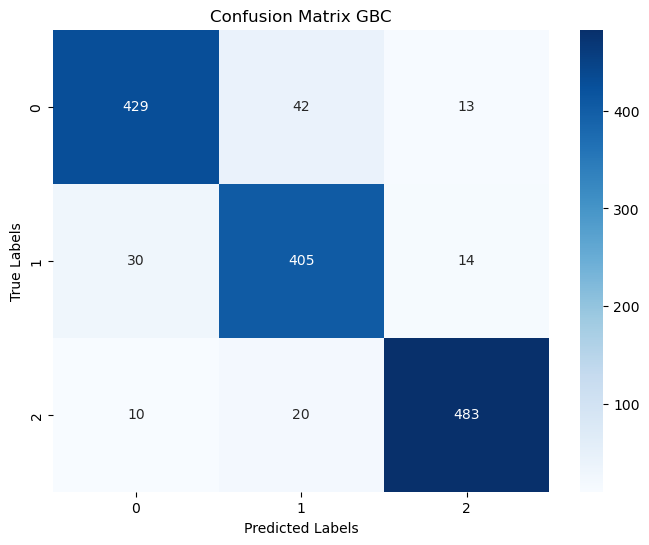

,Model,Best CV Score,Validation Accuracy,Test Accuracy,Best Parameters
1,GBC,0.898473,0.905947,0.910788,"{'model__learning_rate': 0.1, 'model__max_dept..."
0,RFC,0.859935,0.870678,0.872752,"{'model__max_depth': 30, 'model__min_samples_l..."


In [ ]:
param_grid = {
  "RFC":{
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [None, 10, 20, 30],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4],
  },
  "GBC": {
        'model__n_estimators': [100, 200, 300],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__max_depth': [3, 5, 7]
  }
    }

names = ["RFC", "GBC"]
models = get_selected_models(names)
metric = make_scorer(accuracy_score)
val_grid_search_selected_models(names, models, X, y, metric, preprocessor, param_grid)

# We managed to get a test accuracy of 91% with GBC. We have made a great progress. Let's see if we can reduce the dimensionality using PCA analysis

In [ ]:
pca_analysis(X, preprocessor)

,Number of Components,Cumulative Explained Variance
0,1,0.230062
1,2,0.340213
2,3,0.422833
3,4,0.491837
4,5,0.556182
5,6,0.618629
6,7,0.677976
7,8,0.733909
8,9,0.781512
9,10,0.819062


# 70-90% of the variance is in the columns from 8-13. Lets play around and see what are the best columns with our best GBC model

# F-STAT

In [ ]:
names = ["GBC"]
models = [
  GradientBoostingClassifier(learning_rate=0.2,max_depth=7, n_estimators=300),
]

variance_window = range(9,17+1)
metric = f_classif
test_k_best_columns(names, models, X, y, metric,'F-Stat', variance_window, preprocessor)

Average total Score: 0.9041930912452352


,Model,Col #,Metric,Mean,STD
8,GBC,17,F-Stat,0.911471,0.007031
7,GBC,16,F-Stat,0.909845,0.006275
2,GBC,11,F-Stat,0.909084,0.004232
3,GBC,12,F-Stat,0.908531,0.004286
1,GBC,10,F-Stat,0.908289,0.003574
5,GBC,14,F-Stat,0.908220,0.003954
4,GBC,13,F-Stat,0.907390,0.004692
6,GBC,15,F-Stat,0.906560,0.004137
0,GBC,9,F-Stat,0.868347,0.006382


# GBC out performs RFC with far less columns, let's test our model with Mutual Information

In [ ]:
names = ["GBC"]
models = [
  GradientBoostingClassifier(learning_rate=0.2,max_depth=7, n_estimators=300),
]

variance_window = range(9,17+1)
metric = mutual_info_classif
test_k_best_columns(names, models, X, y, metric,'Mutal-Information', variance_window, preprocessor)

Average total Score: 0.9016917990756672


,Model,Col #,Metric,Mean,STD
5,GBC,14,Mutal-Information,0.905488,0.005047
7,GBC,16,Mutal-Information,0.905177,0.005178
8,GBC,17,Mutal-Information,0.904450,0.005912
4,GBC,13,Mutal-Information,0.903759,0.005028
6,GBC,15,Mutal-Information,0.903724,0.005534
3,GBC,12,Mutal-Information,0.903137,0.005468
1,GBC,10,Mutal-Information,0.898468,0.005953
2,GBC,11,Mutal-Information,0.896566,0.005340
0,GBC,9,Mutal-Information,0.894457,0.011417


# Let's test out the K-Best columns with our best model and see our final results

Best score for GBC: 0.892
Best parameters: {'model__learning_rate': 0.2, 'model__max_depth': 7, 'model__n_estimators': 300}
Validation Test accuracy for GBC: 0.896
Test accuracy for GBC: 0.900
---------------------------------------------------------------
              precision    recall  f1-score   support

           1       0.92      0.87      0.89       484
           2       0.85      0.90      0.87       449
           3       0.93      0.93      0.93       513

    accuracy                           0.90      1446
   macro avg       0.90      0.90      0.90      1446
weighted avg       0.90      0.90      0.90      1446



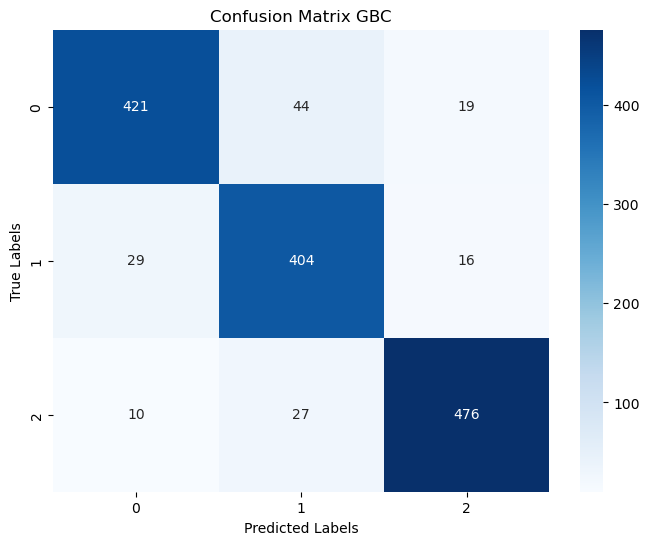

,Model,Best CV Score,Validation Accuracy,Test Accuracy,Best Parameters
0,GBC,0.891951,0.896266,0.899723,"{'model__learning_rate': 0.2, 'model__max_dept..."


In [ ]:
param_grid = {
  "GBC": {
        'model__n_estimators': [300],
        'model__learning_rate': [0.2],
        'model__max_depth': [7]
  }
    }

kbest_metric, metric = SelectKBest(score_func=mutual_info_classif, k=11), make_scorer(accuracy_score)
names = ["GBC"]
models = get_selected_models(names)
val_grid_search_selected_models(names, models, X, y, metric, preprocessor, param_grid, kbest_metric, 'Mutal-Info')

None
Validation Test accuracy for GBC: 0.904
Test accuracy for GBC: 0.903
---------------------------------------------------------------
              precision    recall  f1-score   support

           1       0.91      0.88      0.90       484
           2       0.86      0.89      0.88       449
           3       0.94      0.93      0.93       513

    accuracy                           0.90      1446
   macro avg       0.90      0.90      0.90      1446
weighted avg       0.90      0.90      0.90      1446



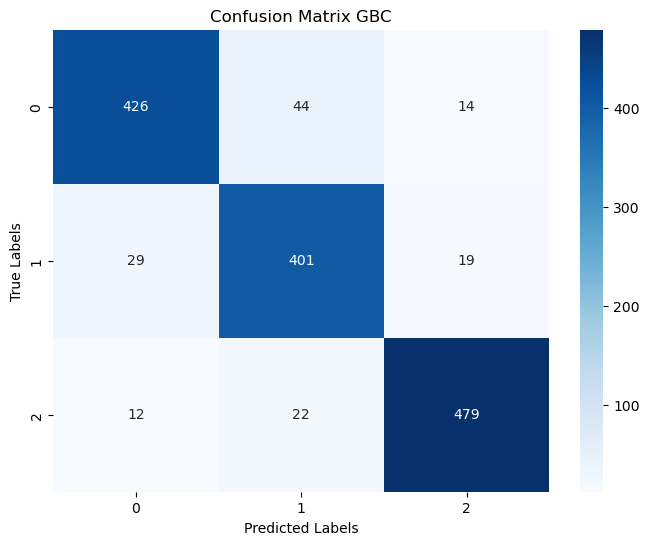

,Model,Validation Accuracy,Test Accuracy
0,GBC,0.903873,0.903181


In [ ]:
kbest_metric = SelectKBest(score_func=mutual_info_classif, k=12)
names = ['GBC']

models = [
  GradientBoostingClassifier(learning_rate=0.2,max_depth=7, n_estimators=300),
]
val_grid_search_selected_models(names, models, X, y, metric, preprocessor, None, kbest_metric, 'Mutal-Info')

# Conclusion: We were able to acheive 90% accuracy and reduce dimensionality to 11 columns. Something to note here, is that we chose to give equal weight to all stages of liver cirrhosis, this approach could be flawed given more medical information in terms of what stage it is best to stop the spread at. So false negatives for stage 1 could be the most detrimental to the patient since its best to stop the cancer as soon as possible. However, if we wanted to create a model that accurately predicted each class, we have acheived that goal. We could adjust this model if needed to meet additional requirments given the modularity of the code.